# COPY Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

<br>
<br>

<br>
<br>

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

<br>
<br>

<br>
<br>

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# plt.style.use('dark_background')
plt.style.use('default')

### 1b. Load the data
Call the variable `cigData`. 

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv', usecols=['Time', '#CigSales'], parse_dates=['Time'], index_col='Time')


## Student Note: This data was altered to obfuscate the fact that it comes from a well-known data set that has nothing to do with cigarette sales.  In fact, the altered version DOES NOT WORK with the exercises given.  

## In the next line, I remove the alteration by subtracting 10e5 and then alter the data by multiplying by 10e3 in order to make a new dataset where the where the scale is roughly the same but the variance is commensurate to the scale.

This alteration will make many of the exercises work (like taking the log to decrease variance)

In [4]:
cigData = (cigData - 1000000) * 100000

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [5]:
cigData.head()

,#CigSales
Time,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [6]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [7]:
cigData.columns

Index(['#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [8]:
cigData.dtypes

#CigSales    int64
dtype: object

Check whether there are any null values. 

In [9]:
cigData.isna().sum()

#CigSales    0
dtype: int64

<br>
<br>

<br>
<br>

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [10]:
# did this during import!

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [11]:
cigData.rename_axis(index={'Time': 'Month'}, inplace=True)

Call a head() to check this has worked. 

In [12]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [13]:
# Did this during import
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [14]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [15]:
display(type(y), y.dtype)

pandas.core.series.Series

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [16]:
cigData.describe()

,#CigSales
count,1.440000e+02
mean,2.802986e+07
std,1.199663e+07
min,1.040000e+07
25%,1.800000e+07
50%,2.655000e+07
75%,3.605000e+07
max,6.220000e+07


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

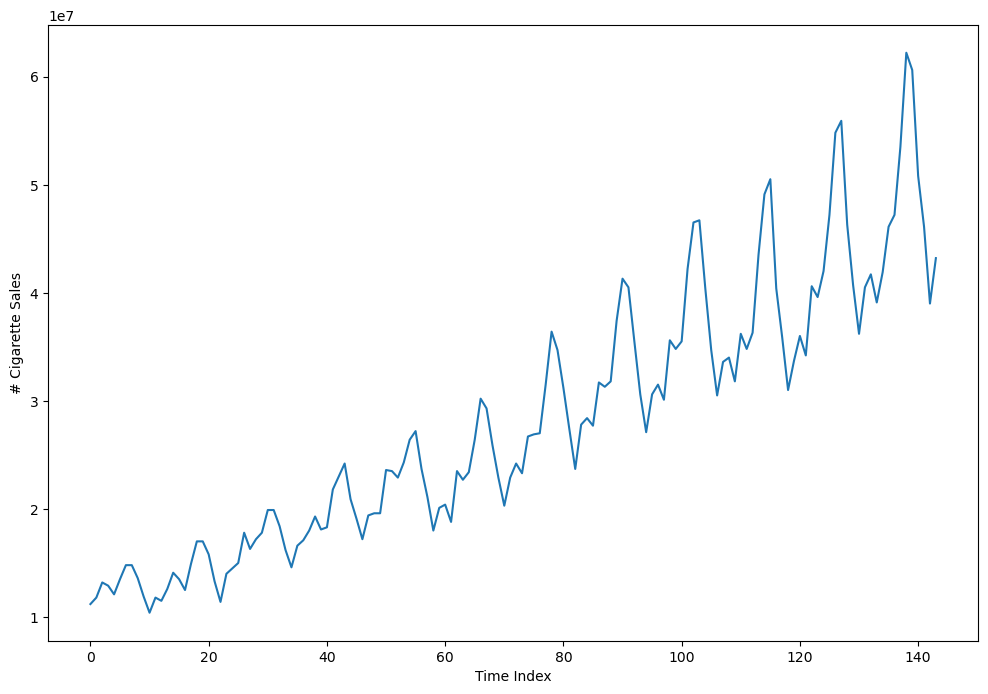

In [17]:


plt.figure(figsize=(12,8))

# plt.subplot(212)
plt.plot(range(len(y)), y)
plt.xlabel('Time Index')
plt.ylabel('# Cigarette Sales')
plt.show()

<br>
<br>

<br>
<br>

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

## Student Note: We see increasing Trend, Seasonality with increasing magnitude, at this scale, it's not particularly easy to distinguish low magnitude seasonality effects from Noise.

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

## Student note: We use a multiplicative model here since the magnitude of the seasonality changes with respect to time.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Month'>

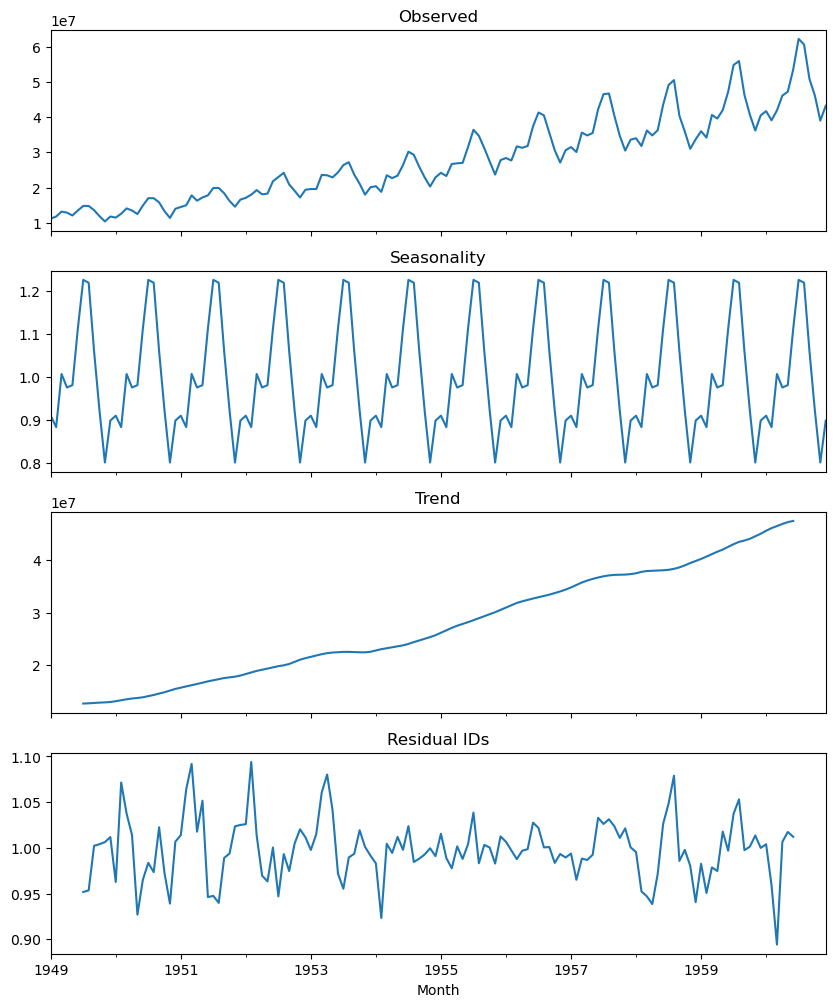

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True)

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')


<br>
<br>

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [19]:
from statsmodels.tsa.stattools import kpss
statistic, p_value, n_lags, critical_values = kpss(cigData, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  1.6513122354165233
p-value:  0.01
Number of Lags:  8
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [20]:
# Another test for stationarity taken from Jose Portilla's Time Series class

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")

In [21]:
adf_test(cigData)

Augmented Dickey-Fuller Test: 

ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is NOT STATIONARY


<br>
<br>

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [22]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [23]:
from sklearn.linear_model import LinearRegression
import datetime as dt


# utility - linear regression
def get_linregr_pred (df: pd.DataFrame) -> np.ndarray:
    """Return a linear regression prediction model from a DataFrame
    
    Keyword Arguments:
    df -- A DataFrame with 'Month' and '#CigSales' columns, holding datetime objects and integer prices
    """
    # @TODO: Assert 'Month' and '#CigSales' columns with datetime and float elements - throw TypeError
    
    # format the data into ndarrays
    df2 = df.reset_index().copy()
    x_arr = df2.Month.map(dt.datetime.toordinal).values.reshape(-1,1)
    y_arr = df2['#CigSales'].values.reshape(-1,1)
    
    # create a linear regression
    linear_regressor = LinearRegression()  
    linear_regressor.fit(x_arr, y_arr)  # fit the model
    y_arr_pred = linear_regressor.predict(x_arr)
    
    return y_arr_pred

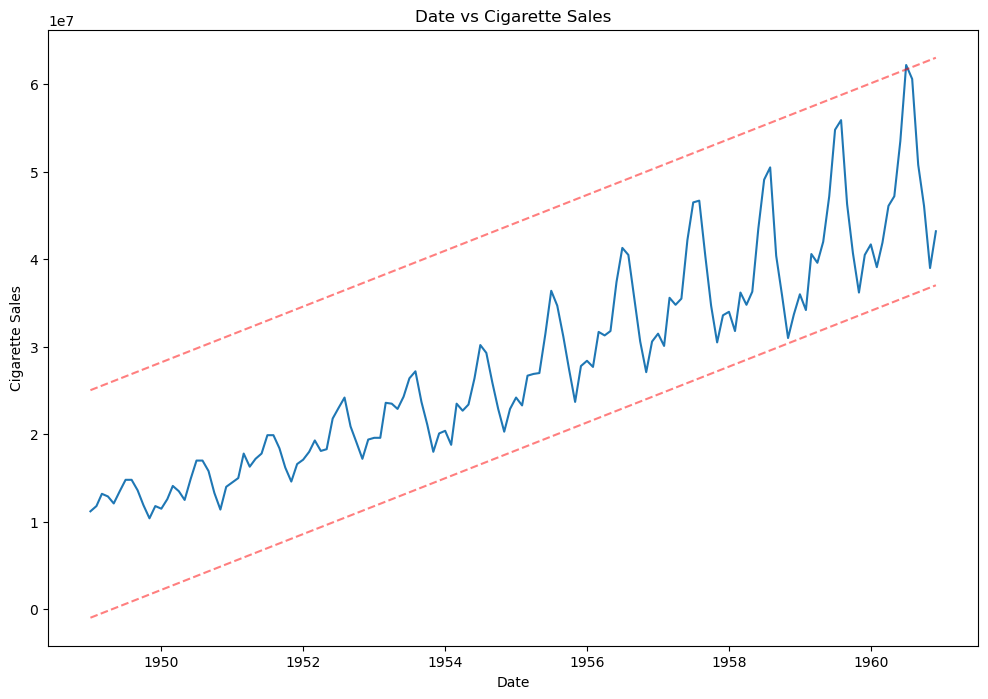

In [100]:
pred = get_linregr_pred(cigData)

plt.figure(figsize=(12,8))
plt.plot(cigData)
plt.plot(cigData.reset_index().Month, pred+1.6e7, color='red', alpha=.5, ls='--')
plt.plot(cigData.reset_index().Month, pred-1e7, color='red', alpha=.5, ls='--')

plt.title('Date vs Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales');

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [25]:
dflog = np.log(cigData)

<br>
<br>


When you plot this, you can see how the variance in our data now remains contant over time.

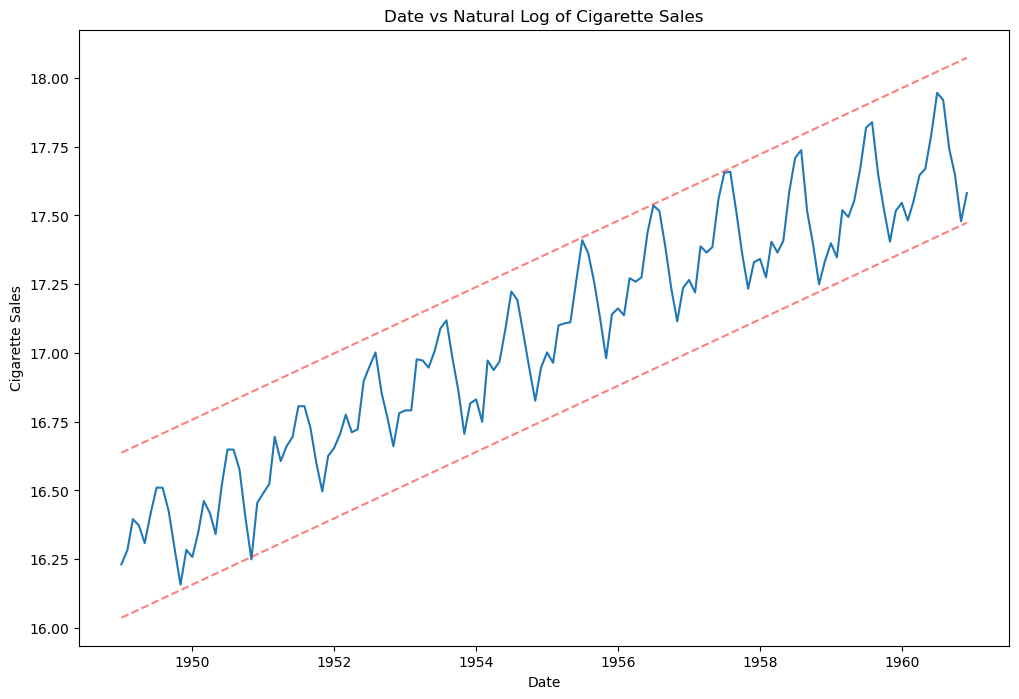

In [101]:
pred = get_linregr_pred(dflog)

plt.figure(figsize=(12,8))
plt.plot(dflog)
plt.plot(cigData.reset_index().Month, pred+.3, color='red', alpha=.5, ls='--')
plt.plot(cigData.reset_index().Month, pred-.3, color='red', alpha=.5, ls='--')

plt.title('Date vs Natural Log of Cigarette Sales')
plt.xlabel('Date')
plt.ylabel('Cigarette Sales');

<br>
<br>

## Student Note: Test the effect of our power transformation on the variance by taking the histogram and checking for uniformity or decreased skew

Text(0.5, 1.0, 'Log cigData histogram')

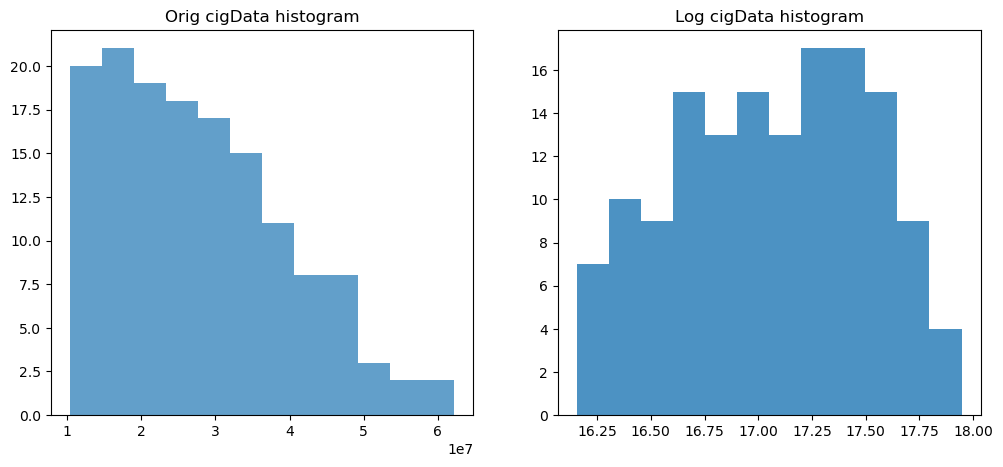

In [27]:

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(cigData, bins=12, alpha=0.7)
plt.title('Orig cigData histogram')
plt.subplot(122)
plt.hist(dflog, bins=12, alpha=0.8)
plt.title('Log cigData histogram')

<br>
<br>
<br>
<br>

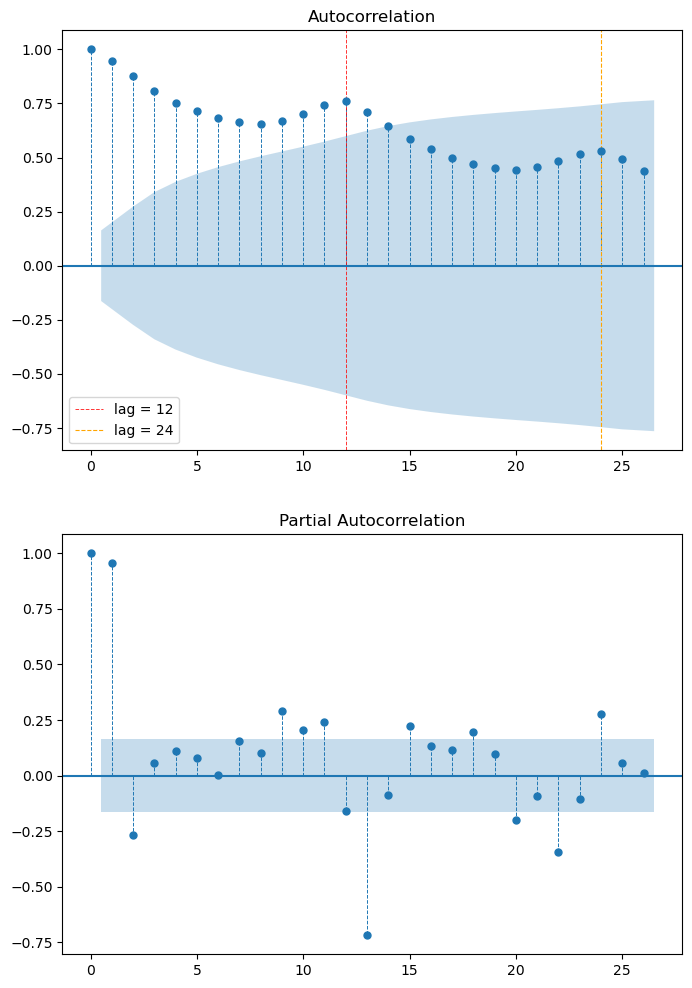

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(8,12))
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')

ax[0].legend()

plot_acf(cigData, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)
plot_pacf(cigData, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)
plt.show()


<br>
<br>

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [53]:
dfdiff = dflog.diff(12)
dfdiff = dfdiff.iloc[12:]

<br>
<br>

## Student Note: When differencing with period=12, we can clearly see some economic effects.  I did some research into those visible dips and we can clearly see the effect on sales of the 1953-1954 Recession caused by the sharp increase in interest rates
## We also see the effect of the 1958 Recession

references: 
* https://en.wikipedia.org/wiki/Recession_of_1953 
* https://en.wikipedia.org/wiki/Recession_of_1958

Text(0.5, 1.0, 'Differenced Cigarette Sales')

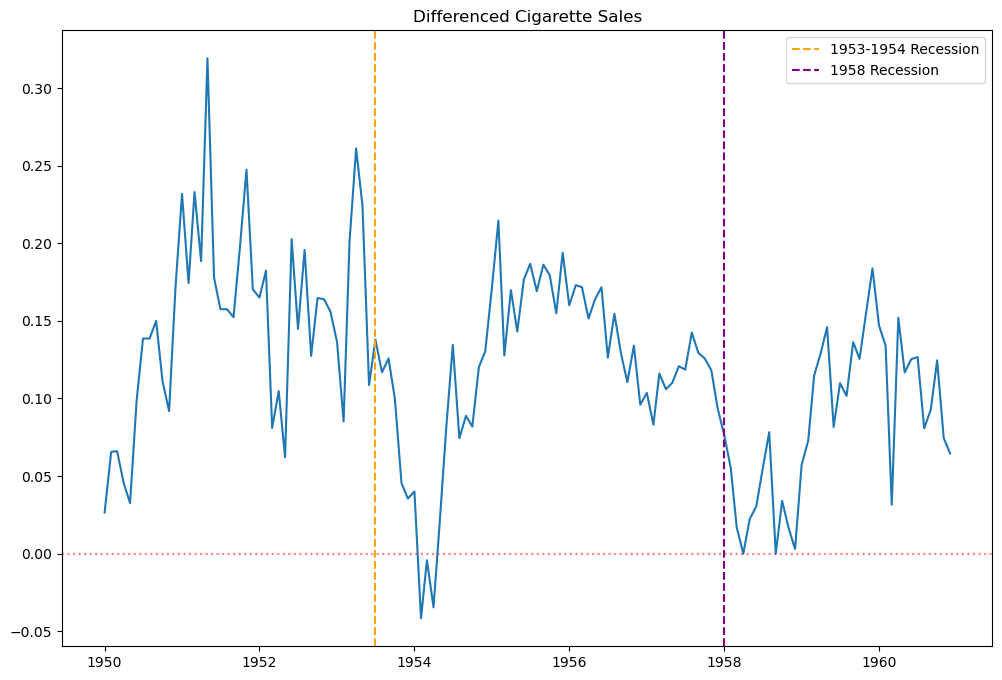

In [54]:
plt.figure(figsize=(12,8))
plt.plot(dfdiff)
plt.axhline(0, color='red', alpha=0.5, ls=':')
plt.axvline('1953-07', color='orange', ls='--', label='1953-1954 Recession')
plt.axvline('1958-01', color='purple', ls='--', label='1958 Recession')
plt.legend()
plt.title('Differenced Cigarette Sales')



In [30]:
from statsmodels.tsa.stattools import kpss
statistic, p_value, n_lags, critical_values = kpss(dflog.iloc[1:], nlags='auto')

print('KPSS Test Statistic: '.ljust(22), statistic)
print('p-value: '.ljust(22), p_value)
print('Number of Lags: '.ljust(22), n_lags)
print('Critical Values: '.ljust(22), critical_values)

KPSS Test Statistic:   1.6530487674116994
p-value:               0.01
Number of Lags:        8
Critical Values:       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

<br>
<br>

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [31]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pandas.plotting import autocorrelation_plot

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

<br>
<br>

In [32]:
def get_mse(data, order=(0,0,0), seasonal_order=(0,0,0,0)):
    
    # Train-Test split validation is 24 months
    X = data.iloc[:len(data)-24]
    y = data.drop(X.index)
      
    # define and fit the model
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(y))
    
    # return the MSE
    return mean_squared_error(y, pred)

<br>
<br>

## Student Note: Use auto_arima to find the best model.  Here we see it's a SARIMAX with using seasonality: p=2, d=0, q=0, ps=0, pd=1, pq=1, period=12

In [33]:

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

X = dflog.iloc[:len(dfdiff)-24]
y = dflog.drop(X.index)

auto_arima(X, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 179.876
Date:                            Thu, 10 Dec 2020   AIC                           -347.752
Time:                                    11:22:53   BIC                           -332.366
Sample:                                         0   HQIC                          -341.532
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0534      0.025      2.094      0.036       0.003       0.103
ar.L1          0.5708      0.104      5.507      0.000       0.368       0.774
ar.L2          0.2089      0.099      2.107      0.035       0.015       0.403
ar.S.L12      -0.5616      0.118     -4.756      0.000      -0.793      -0.330
ar.S.L24      -0.2668      0.140     -1.905      0.057      -0.541       0.008
sigma2         0.0013      0.000      6.976      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.92   Jarque-Bera (JB):                 6.99
Prob(Q):                              0.56   Prob(JB):                         0.03
Heteroskedasticity (H):               0.28   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

print('MSE: ', get_mse(dflog, (0,1,1)) ) 

MSE:  0.08785456045365596


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [35]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.

def get_pdq (data):
    i = 0
    mses = pd.DataFrame()
    for p in range(0,2):
        for d in range(0,2):
            for q in range (0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                            mse = get_mse(data, order=(p,d,q), seasonal_order=(ps,ds,qs,12))
                            mses = mses.append(
                                pd.DataFrame({'p':p, 
                                              'd':d, 
                                              'q':q,
                                              'ps':ps,
                                              'ds':ds,
                                              'qs':qs,
                                              'mse':mse}, index=[i]))
                            i = i+1
             
    mses = mses.sort_values(by='mse', axis=0, ascending=True).reset_index()
    return mses.iloc[0]

In [36]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!

pdq = get_pdq(dflog)

print('mse: '.ljust(6), pdq.mse)
print()
print('p:'.ljust(6), int(pdq.p))
print('d:'.ljust(6), int(pdq.d))
print('q:'.ljust(6), int(pdq.q))
print('ps:'.ljust(6), int(pdq.ps))
print('ds:'.ljust(6), int(pdq.ds))
print('qs:'.ljust(6), int(pdq.qs))
print('s:'.ljust(6), 12)


mse:   0.0010356861615354188

p:     1
d:     1
q:     2
ps:    1
ds:    0
qs:    1
s:     12


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [37]:
# define and fit the model
model = SARIMAX(dflog, order=(pdq.p, pdq.d, pdq.q), 
                seasonal_order=(pdq.ps, pdq.ds, pdq.qs, 12), freq='MS')
model_fit = model.fit()

# predict the future!
forecast = model_fit.forecast(24)
pred = model_fit.predict()

model_fit.mse

1.8315641054893546

We can take a look at a summary of the model this library has built around our data.

In [38]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 255.664
Date:                              Thu, 10 Dec 2020   AIC                           -499.329
Time:                                      11:23:32   BIC                           -481.552
Sample:                                  01-01-1949   HQIC                          -492.105
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8486      0.125      6.795      0.000       0.604       1.093
ma.L1         -1.2014      0.153     -7.837      0.000      -1.502      -0.901
ma.L2          0.2397      0.110      2.177      0.029       0.024       0.455
ar.S.L12       0.9906      0.007    140.771      0.000       0.977       1.004
ma.S.L12      -0.5659      0.101     -5.601      0.000      -0.764      -0.368
sigma2         0.0013      0.000      8.473      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       39.51   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.49   Prob(JB):                         0.07
Heteroskedasticity (H):               0.64   Skew:                             0.04
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

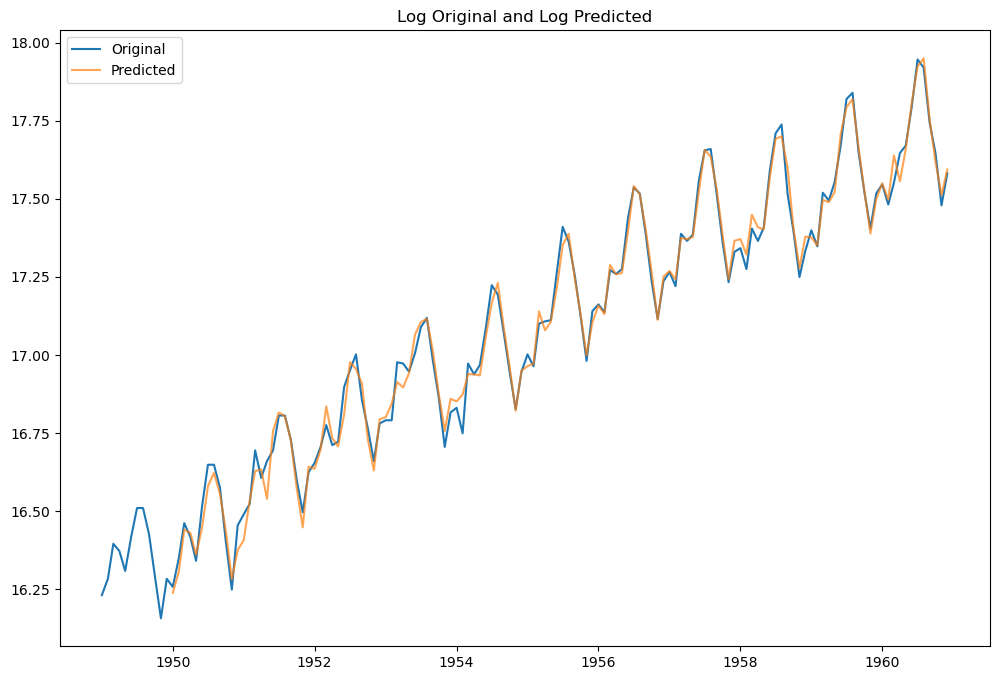

In [39]:
plt.figure(figsize=(12,8))
plt.plot(dflog, label='Original')
plt.plot(pred[12:], alpha=0.7, label='Predicted')
plt.title('Log Original and Log Predicted')
plt.legend()
# plt.plot(forecast)

<br>
<br>

# The following will use the auto_arima results instead of our custom MSE optimizer

In [40]:
# define and fit the model
model = SARIMAX(dflog, order=(2,0,0), seasonal_order=(0, 1, 1, 12), freq='MS')

model_fit_aa = model.fit()

# predict the future!
forecast_aa = model_fit_aa.forecast(24)
pred_aa = model_fit_aa.predict()

model_fit_aa.mse

22.27664030412595

We can take a look at a summary of the model this library has built around our data.

In [41]:
model_fit_aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 244.710
Date:                              Thu, 10 Dec 2020   AIC                           -481.419
Time:                                      11:23:33   BIC                           -469.888
Sample:                                  01-01-1949   HQIC                          -476.734
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6549      0.069      9.526      0.000       0.520       0.790
ar.L2          0.3368      0.070      4.821      0.000       0.200       0.474
ma.S.L12      -0.5559      0.096     -5.781      0.000      -0.744      -0.367
sigma2         0.0014      0.000      8.686      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       43.50   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.32   Prob(JB):                         0.47
Heteroskedasticity (H):               0.55   Skew:                             0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>
<br>

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

<br>
<br>

## 1st model uses the results of our custom grid search

Text(0.5, 1.0, 'Using re-scaled data, seasonality, and an expanded grid search')

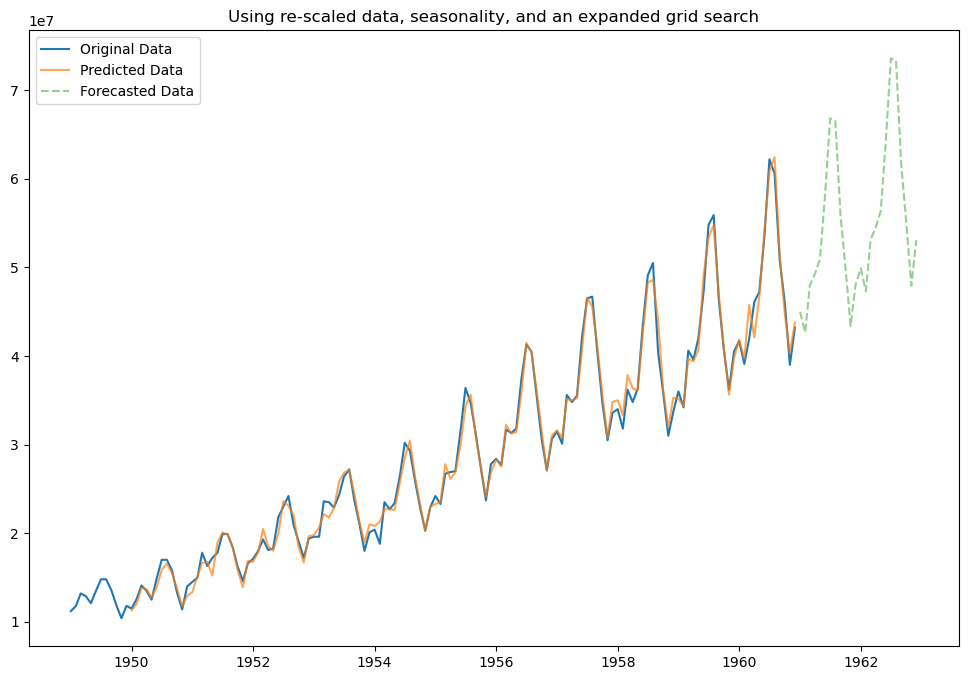

In [42]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(dflog), label='Original Data')
plt.plot(np.exp(pred[12:]), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast), label='Forecasted Data', alpha=0.5, ls='--')
plt.legend()
plt.title('Using re-scaled data, seasonality, and an expanded grid search')

<br>
<br>

## 2nd model uses auto_arima

Text(0.5, 1.0, 'Auto Arima Version')

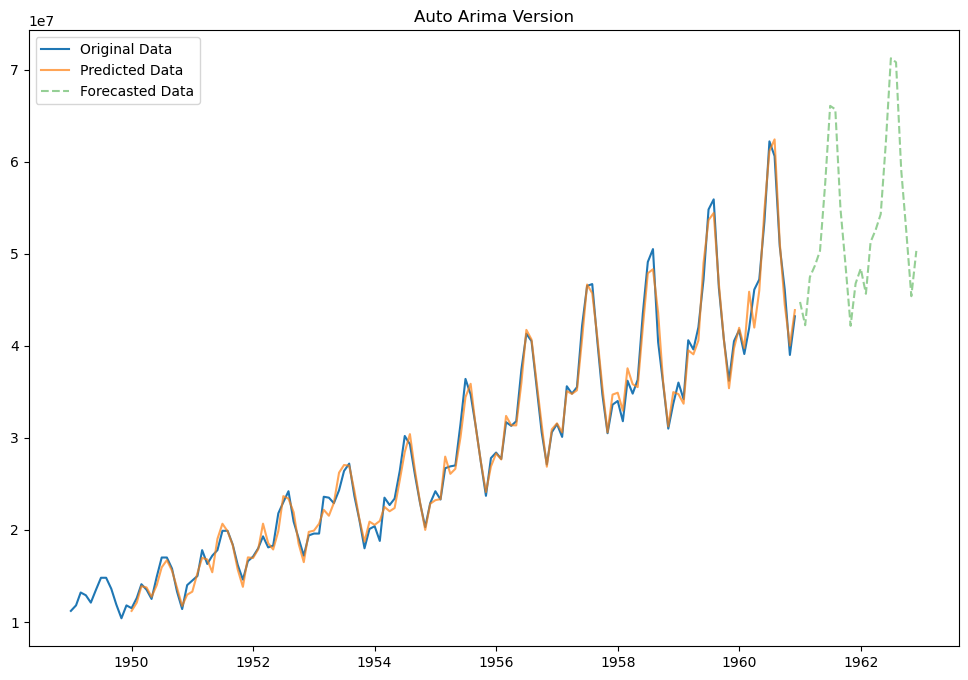

In [43]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(dflog), label='Original Data')
plt.plot(np.exp(pred_aa[12:]), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast_aa), label='Forecasted Data', alpha=0.5, ls='--')
plt.legend()
plt.title('Auto Arima Version')

<br>
<br>

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [44]:
# # Declare a variable called forecast_period with the amount of months to forecast, and
# # create a range of future dates that is the length of the periods you've chosen to forecast
# _ _ _

# # Convert that range into a dataframe that includes your predictions
# _ _ _

# # Plot your future predictions
# _ _ _

<br>
<br>

<br>
<br>

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 